# Car vs Bike Image Classification

<div class="sc-emEvRq gZqHzs sc-hGFITe jXToHY"><p>The "Car vs Bike - Image Classification" dataset is a collection of images downloaded from various sources, containing photographs of both cars and bikes. This dataset has been compiled for the purpose of training and evaluating image classification algorithms.</p>
<p>The dataset contains a total of 4000 images. The images have been labeled as either "Car" or "Bike" and are stored in separate directories.</p>
<p>This dataset can be used for a variety of tasks related to image classification, including developing and testing deep learning algorithms, evaluating the effectiveness of different image features and classification techniques, and comparing the performance of different models.</p>
<p>Researchers and practitioners interested in using this dataset are encouraged to cite the original sources of the images and to acknowledge any modifications made to the dataset for their particular use. The dataset may be useful for tasks such as automated bikes sorting or road worthiness analysis.</p>
<p>This data set is a collection of 2,000 Bike and Car images. While collecting these images, it was made sure that all types of bikes and cars are included in the image collection. This is because of the high Intra-variety of cars and bikes. That is, there are different types of cars and bikes, which make it a little tough task for the model because the model will also have to understand the high variety of bikes and cars. But if your model is able to understand the basic structure of a car and a bike, it will be able to distinguish between both classes.</p>

<p>The data is not preprocessed. This is done intentionally so that one can apply the augmentations you want to use. Almost all the 2000 images are unique. So after applying some data augmentation, you can increase the size of the data set.

The data is not distributed into training and validation subsets. But one can easily do so by using an Image data generator from Keras.</p>
</div>

In [8]:
# importing the neccessary libraries
import os
import numpy as np
import seaborn as sns
import zipfile
import shutil
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings("ignore")

## Downloading, unzipping, and collecting the data from the file

In [2]:
# Unziping the combined dataset
combined_zip_path = 'archive (6).zip'
extract_dir = 'Car-Bike'

with zipfile.ZipFile(combined_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [3]:
# Defining directories for training and validation images
train_dir = 'training'
validation_dir = 'validation'

In [4]:
# Creating directories for final training and validation sets
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# Also defining directories for Bike and Car within the extracted directory
combined_bike_dir = os.path.join(extract_dir, 'Car-Bike-Dataset/Bike')
combined_car_dir = os.path.join(extract_dir, 'Car-Bike-Dataset/Car')

In [5]:
# Creating directories for Cars and Bikes within the training and validation directories
train_car_dir = os.path.join(train_dir, 'Car')
train_bike_dir = os.path.join(train_dir, 'Bike')
validation_car_dir = os.path.join(validation_dir, 'Car')
validation_bike_dir = os.path.join(validation_dir, 'Bike')

In [6]:
# Create directories for car and bike validation
os.makedirs(validation_car_dir, exist_ok=True)
os.makedirs(validation_bike_dir, exist_ok=True)

# Split images into training and validation sets
train_car_fnames, validation_car_fnames = train_test_split(os.listdir(combined_car_dir), test_size=0.2, random_state=42)
train_bike_fnames, validation_bike_fnames = train_test_split(os.listdir(combined_bike_dir), test_size=0.2, random_state=42)

In [7]:
# Move Car images to final training and validation directories
for fname in train_car_fnames:
    src_path = os.path.join(combined_car_dir, fname)
    dst_path = os.path.join(train_car_dir, fname)
    shutil.move(src_path, dst_path)

for fname in validation_car_fnames:
    src_path = os.path.join(combined_car_dir, fname)
    dst_path = os.path.join(validation_car_dir, fname)
    shutil.move(src_path, dst_path)

# Move Bike images to final training and validation directories
for fname in train_bike_fnames:
    src_path = os.path.join(combined_bike_dir, fname)
    dst_path = os.path.join(train_bike_dir, fname)
    shutil.move(src_path, dst_path)

for fname in validation_bike_fnames:
    src_path = os.path.join(combined_bike_dir, fname)
    dst_path = os.path.join(validation_bike_dir, fname)
    shutil.move(src_path, dst_path)

# Print the counts of files in each category
print('Total Car Training files:', len(train_car_fnames))
print('Total Car Validation files:', len(validation_car_fnames))
print('Total Bike Training files:', len(train_bike_fnames))
print('Total Bike Validation files:', len(validation_bike_fnames))

Total Car Training files: 1600
Total Car Validation files: 400
Total Bike Training files: 1600
Total Bike Validation files: 400


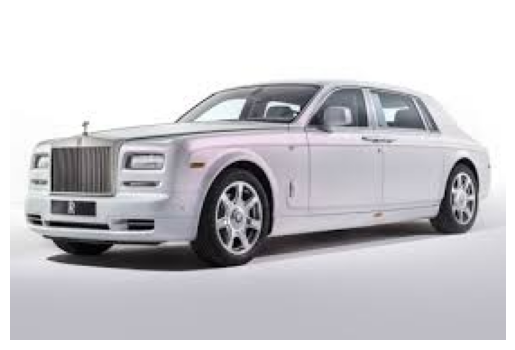

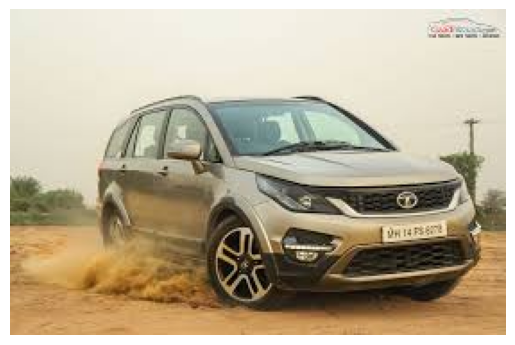

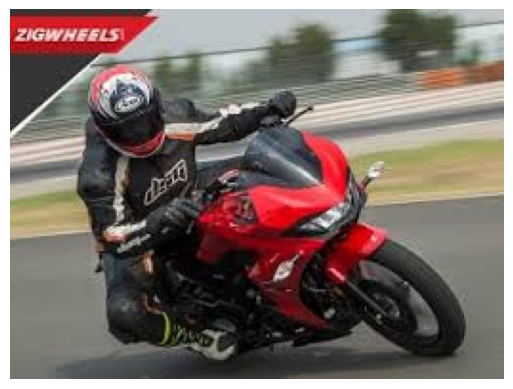

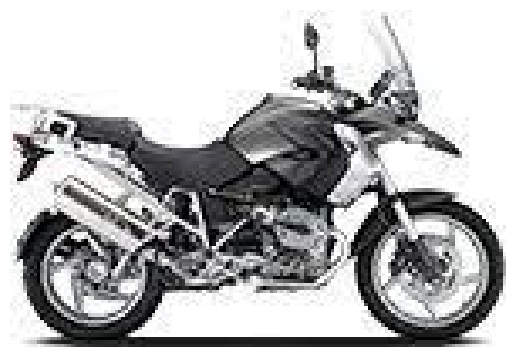

In [10]:
pic_index = 2

next_car = [os.path.join(train_car_dir, fname) 
                for fname in train_car_fnames[pic_index-2:pic_index]]
next_bike = [os.path.join(train_bike_dir, fname) 
                for fname in train_bike_fnames[pic_index-2:pic_index]]


for i, img_path in enumerate(next_car + next_bike):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

In [11]:
# Adding our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                  rotation_range = 40,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True)

# Note that our validation data should not be augmented
test_datagen = ImageDataGenerator(rescale = 1./255.)

In [12]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                   batch_size = 20,
                                                   class_mode = 'binary',
                                                   target_size = (150, 150),
                                                    classes=['Bike', 'Car']
                                                   )
# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       batch_size = 20,
                                                       class_mode = 'binary',
                                                       target_size = (150, 150),
                                                        classes=['Bike', 'Car']
                                                       )

Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


#### Function to display graph of loss vs accuracy

In [13]:
def plot_graph(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  plt.show()

In [14]:
# Defining a Callback class that stops training once accuracy reaches 99.9% We dont want to overfit our model.
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [15]:
# Callback for early stopping. If training loss didnt improve after 10 epoch stop training
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

### Building Models

#### CNN Model

In [16]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation = 'relu', input_shape = (150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0 and 1 where 0 will be 'bike' and 1 for 'car'
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
cnn_model.compile(optimizer = RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [17]:
batch_size = 20
train_steps_per_epoch = len(train_car_fnames) // batch_size
val_steps_per_epoch = len(validation_car_fnames) // batch_size
callbacks = myCallback()

cnn_history = cnn_model.fit(
                    train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = train_steps_per_epoch * 2,
                    epochs = 100,
                    validation_steps = val_steps_per_epoch,
                    verbose = 1,
                    callbacks = [callbacks, es_callback]
                    )

Epoch 1/100
160/160 [==============================] - 135s 828ms/step - loss: 0.7437 - accuracy: 0.5944 - val_loss: 0.5602 - val_accuracy: 0.7400
Epoch 2/100
160/160 [==============================] - 111s 696ms/step - loss: 0.5511 - accuracy: 0.7306 - val_loss: 0.2445 - val_accuracy: 0.9125
Epoch 3/100
160/160 [==============================] - 109s 679ms/step - loss: 0.4710 - accuracy: 0.7891 - val_loss: 0.5086 - val_accuracy: 0.7275
Epoch 4/100
160/160 [==============================] - 116s 725ms/step - loss: 0.4270 - accuracy: 0.8019 - val_loss: 0.2170 - val_accuracy: 0.9025
Epoch 5/100
160/160 [==============================] - 117s 729ms/step - loss: 0.3705 - accuracy: 0.8413 - val_loss: 0.1824 - val_accuracy: 0.9275
Epoch 6/100
160/160 [==============================] - 109s 683ms/step - loss: 0.3443 - accuracy: 0.8531 - val_loss: 0.2073 - val_accuracy: 0.9125
Epoch 7/100
160/160 [==============================] - 111s 694ms/step - loss: 0.3336 - accuracy: 0.8581 - val_loss: 0

#### Basic CNN Accuracy

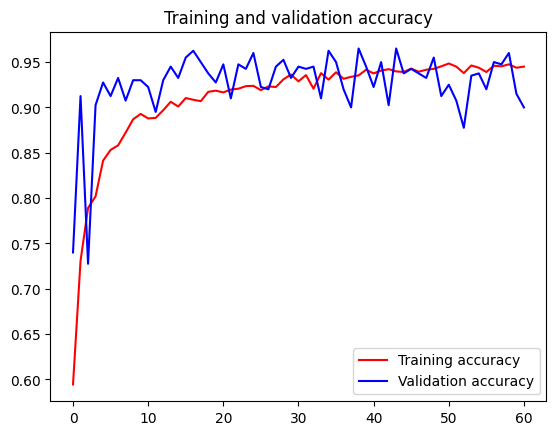

<Figure size 640x480 with 0 Axes>

In [18]:
plot_graph(cnn_history)

Well, the training stopped after the 61st epoch with slight improvement but we will try to improve it by using Transfer learning.

#### InceptionV3

In [21]:
pre_trained_inception_model = InceptionV3(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

87910968/87910968 [==============================] - 102s 1us/step


### FREEZING

#### Functional API to merge both our model and the pretrained inception model

In [27]:
def build_model(pretrained_model):
  # Making all the layers in the pre-trained model non-trainable
  for layer in pretrained_model.layers:
    layer.trainable = False
  last_layer = pretrained_model.get_layer('mixed7')
  print('last layer output shape: ', last_layer.output_shape)
  last_output = last_layer.output
  # Flattening the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Adding a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Adding a dropout rate of 0.2
  x = layers.Dropout(0.2)(x)                  
  # Adding a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)           

  model = Model(pretrained_model.input, x) 

  model.compile(optimizer = RMSprop(learning_rate = 0.001), 
                loss = 'binary_crossentropy', 
                metrics = ['accuracy'])
  return model

#### Training the Model

In [28]:
batch_size = 20

train_steps_per_epoch = len(train_car_fnames) // batch_size
val_steps_per_epoch = len(validation_car_fnames) // batch_size
callbacks = myCallback()
inception_model = build_model(pre_trained_inception_model)

inception_history = inception_model.fit(
                    train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = train_steps_per_epoch * 2,
                    epochs = 100,
                    validation_steps = val_steps_per_epoch,
                    verbose = 1,
                    callbacks = [callbacks, es_callback]
                    )

last layer output shape:  (None, 7, 7, 768)
Epoch 1/100
160/160 [==============================] - 113s 689ms/step - loss: 0.5618 - accuracy: 0.9194 - val_loss: 0.0796 - val_accuracy: 0.9775
Epoch 2/100
160/160 [==============================] - 107s 669ms/step - loss: 0.1327 - accuracy: 0.9525 - val_loss: 0.1100 - val_accuracy: 0.9775
Epoch 3/100
160/160 [==============================] - 107s 667ms/step - loss: 0.1147 - accuracy: 0.9669 - val_loss: 0.0224 - val_accuracy: 0.9900
Epoch 4/100
160/160 [==============================] - 107s 666ms/step - loss: 0.1033 - accuracy: 0.9650 - val_loss: 0.1250 - val_accuracy: 0.9825
Epoch 5/100
160/160 [==============================] - 106s 665ms/step - loss: 0.0648 - accuracy: 0.9809 - val_loss: 0.1214 - val_accuracy: 0.9825
Epoch 6/100
160/160 [==============================] - 108s 673ms/step - loss: 0.0863 - accuracy: 0.9728 - val_loss: 0.0860 - val_accuracy: 0.9875
Epoch 7/100
160/160 [==============================] - 107s 670ms/step - l

#### Model Accuracy

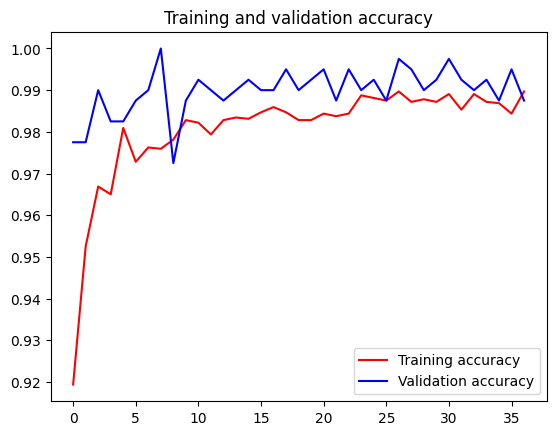

<Figure size 640x480 with 0 Axes>

In [29]:
plot_graph(inception_history)

#### VGG16

In [31]:
pre_trained_VGG16_model = VGG16(
    input_shape=(150, 150, 3),
    include_top=False,
    weights='imagenet'
)

58889256/58889256 [==============================] - 19s 0us/step


#### Functional API to merge both our model and the pretrained VGG16 model

In [33]:
def build_model(pretrained_model):
    # Making all the layers in the pre-trained model non-trainable
    for layer in pretrained_model.layers:
        layer.trainable = False

    # Flattening the output layer to 1 dimension
    x = layers.Flatten()(pretrained_model.output)

    # Adding a fully connected layer with 1,024 hidden units and ReLU activation
    x = layers.Dense(1024, activation='relu')(x)

    # Adding a dropout rate of 0.2
    x = layers.Dropout(0.2)(x)

    # Adding a final sigmoid layer for binary classification
    x = layers.Dense(1, activation='sigmoid')(x)

    model = Model(pretrained_model.input, x)

    model.compile(optimizer=RMSprop(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

Epoch 1/100
160/160 [==============================] - 329s 2s/step - loss: 0.5966 - accuracy: 0.8606 - val_loss: 0.1068 - val_accuracy: 0.9575
Epoch 2/100
160/160 [==============================] - 311s 2s/step - loss: 0.2075 - accuracy: 0.9212 - val_loss: 0.1796 - val_accuracy: 0.9400
Epoch 3/100
160/160 [==============================] - 314s 2s/step - loss: 0.1752 - accuracy: 0.9316 - val_loss: 0.0554 - val_accuracy: 0.9800
Epoch 4/100
160/160 [==============================] - 313s 2s/step - loss: 0.1609 - accuracy: 0.9425 - val_loss: 0.0997 - val_accuracy: 0.9500
Epoch 5/100
160/160 [==============================] - 313s 2s/step - loss: 0.1503 - accuracy: 0.9419 - val_loss: 0.0869 - val_accuracy: 0.9775
Epoch 6/100
160/160 [==============================] - 316s 2s/step - loss: 0.1483 - accuracy: 0.9463 - val_loss: 0.0836 - val_accuracy: 0.9750
Epoch 7/100
160/160 [==============================] - 316s 2s/step - loss: 0.1289 - accuracy: 0.9522 - val_loss: 0.1283 - val_accuracy:

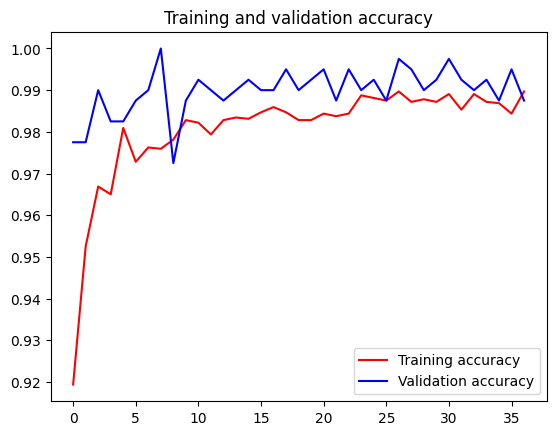

<Figure size 640x480 with 0 Axes>

In [34]:
vgg16_model = build_model(pre_trained_VGG16_model)
vgg16_model_history = vgg16_model.fit(
                    train_generator,
                    validation_data = validation_generator,
                    steps_per_epoch = train_steps_per_epoch * 2,
                    epochs = 100,
                    validation_steps = val_steps_per_epoch,
                    verbose = 1,
                    callbacks=[callbacks, es_callback]
                    )
plot_graph(inception_history)

### EVALUATION

#### CNN

In [38]:
results = cnn_model.evaluate(validation_generator, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.34824
Test Accuracy: 89.88%


#### INCEPTION

In [39]:
results = inception_model.evaluate(validation_generator, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.17128
Test Accuracy: 99.12%


#### VGG16

In [40]:
results = vgg16_model.evaluate(validation_generator, verbose=0)

print("Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

Test Loss: 0.06371
Test Accuracy: 98.62%


In [57]:
# Saving the CNN-based model
cnn_model.save('cnn_model.h5')

In [55]:
# Saving the InceptionV3-based model
inception_model.save('inception_model.h5')

In [56]:
# Saving the VGG16-based model
vgg16_model.save('vgg16_model.h5')